In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# suppress warnings to run smoothly the code
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy.stats import norm
# data cleaning
import string
import re
# for removing accented and special chracters
import unicodedata
# for stopwords removal
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# for calculating Polarity and Subjectivity
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
# load in all the modules we are going to need
import nltk
import collections
# for Wordscloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

Link to data source: https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews

The dataset I considered for this code is an alternative one with a focus on the customer reviews for products bought on Amazon. This has more than 500,000 records starting from 1999 till 2012 and the main indicators are: score, text, and helpfulness numerator/denominator along with their respective time period. It would be very useful to make investment decisions based on sentiment analysis taking into account polarity and subjectivity because it would give a sense of how the stock would perform according to the assessed sentiment. Another use is still related to the sentiment analysis, but in this case we could consider a set of words that are classified as negative, positive, litigious, …
An hypothesis of investment strategy might be related to open positions on Amazon stock in accordance with its polarity, buying when there is a positive sentiment and selling in an opposite scenario

## Dataset and cleaning

In [2]:
# loading the csv file for reviews
df= pd.read_csv('Reviews.csv')
# converting timestamps to datetime in order to have a readable dataset with the right dates for a time series analysis
df["Time"] = pd.to_datetime(df["Time"],unit="s")

In [3]:
# show some data from the DataFrame
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# show the DataFrame informatiom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      568454 non-null  int64         
 1   ProductId               568454 non-null  object        
 2   UserId                  568454 non-null  object        
 3   ProfileName             568438 non-null  object        
 4   HelpfulnessNumerator    568454 non-null  int64         
 5   HelpfulnessDenominator  568454 non-null  int64         
 6   Score                   568454 non-null  int64         
 7   Time                    568454 non-null  datetime64[ns]
 8   Summary                 568427 non-null  object        
 9   Text                    568454 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 43.4+ MB


In [5]:
# checking how many values are null in each column
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [6]:
# drop null values not replacing it but eliminating the entire row from the dataset to have the whole dataset which is coherent
df.dropna(inplace=True)

In [7]:
# re-check if there are null values
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [8]:
# run some statistics for the DataFrame with quantiles, mean, …
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score
count,568411.000000,568411.000000,568411.000000,568411.000000
mean,284227.440964,1.743874,2.227876,4.183309
std,164099.020907,7.636781,8.288752,1.310368
min,1.000000,0.000000,0.000000,1.000000
25%,142114.500000,0.000000,0.000000,4.000000
50%,284224.000000,0.000000,1.000000,5.000000
75%,426341.500000,2.000000,2.000000,5.000000
max,568454.000000,866.000000,923.000000,5.000000


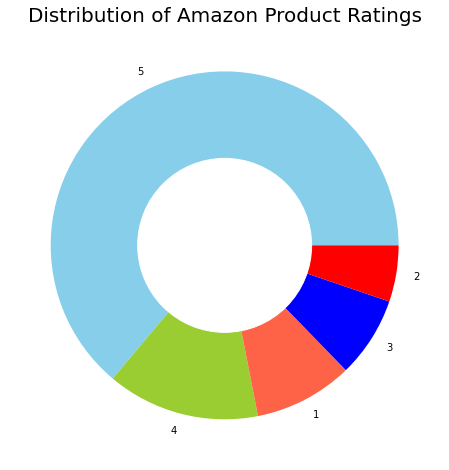

In [9]:
# plot the different scores to have a better visualization of the data ratings
review_score = df["Score"].value_counts()
numbers = review_score.index
quantity = review_score.values

custom_colors = ["skyblue", "yellowgreen", 'tomato', "blue", "red"]
plt.figure(figsize=(10, 8))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Distribution of Amazon Product Ratings", fontsize=20)
plt.show()

In [10]:
# remove punctuations from the Reviews DataFrame text
def remove_punctuation(raw_txt):
    clean_list = [char for char in raw_txt if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

# remove numbers from the Reviews DataFrame text
def remove_numbers(raw_txt):
    list_text_new = []
    for i in raw_txt:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ''.join(list_text_new)

# remove accented characters from the Reviews DataFrame text
def remove_accented_chars(raw_txt):
    new_text = unicodedata.normalize('NFKD', raw_txt).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

# remove special characters from the Reviews DataFrame text
def remove_special_chars(raw_txt):
    pat = r'[^a-zA-z0-9]' 
    return re.sub(pat, ' ', raw_txt)

In [11]:
# apply the punctuation removal function
df["Text"] = df["Text"].apply(remove_punctuation)

In [12]:
# apply the number removal function
df["Text"] = df["Text"].apply(remove_numbers)

In [13]:
# apply the accented characters removal function
df["Text"] = df.apply(lambda x: remove_accented_chars(x["Text"]), axis = 1)

In [14]:
# apply the special characters removal function
df["Text"] = df.apply(lambda x: remove_special_chars(x["Text"]), axis = 1)

In [15]:
df["Text"].head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price  There was a wide...
Name: Text, dtype: object

In [16]:
# calculate the length of the "Text" Reviews and add it as a new column to the DataFrame
df["length"] = df["Text"].apply(len)

In [17]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,260
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,183
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,491
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,214
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price There was a wide...,135


In [18]:
# calculate the character count of the "Text" Reviews and add it as a new column to the DataFrame
df["char_count"] = df["Text"].apply(len)

In [19]:
# calculate the word count of the "Text" Reviews and add it as a new column to the DataFrame
df["word_count"] = df["Text"].apply(lambda x: len(x.split()))

In [20]:
# calculate the word density of the "Text" Reviews and add it as a new column to the DataFrame
df["word_density"] = df["char_count"] / (df["word_count"]+1)

In [21]:
punctuation = string.punctuation
# calculate the punctuation count of the "Text" Reviews and add it as a new column to the DataFrame
df["punctuation_count"] = df["Text"].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 

In [22]:
# run some statistics on the newly created columns for the DataFrame with quantiles, mean, …
df[["char_count","word_count","word_density","punctuation_count"]].describe()

,char_count,word_count,word_density,punctuation_count
count,568411.000000,568411.000000,568411.000000,568411.0
mean,417.126368,79.223360,5.135579,0.0
std,421.209773,78.165772,0.382037,0.0
min,12.000000,0.000000,1.909091,0.0
25%,173.000000,33.000000,4.892857,0.0
50%,290.000000,56.000000,5.120690,0.0
75%,505.000000,97.000000,5.357143,0.0
max,20560.000000,3393.000000,26.000000,0.0


In [23]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length,char_count,word_count,word_density,punctuation_count
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,260,260,48,5.306122,0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,183,183,31,5.718750,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,491,491,92,5.279570,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,214,214,41,5.095238,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price There was a wide...,135,135,27,4.821429,0


## Advanced technique: sentiment analysis

The sentiment analysis that follows as aforementioned relies on the polarity of text rather than subjectivity or words with a specific sentiment. The insights from this analysis are that polarity is quite low whilst subjectivity is more than double. This indicates that reviews are driven by subjectivity patterns and should be carefully analyzed. Nonetheless, a positive result for the polarity determines an average slightly positive sentiment analysis. The distribution of subjectivity is more centered and it seems a "bell" (normal) distribution (although we could have high extreme values -> high kurtosis), whereas the polarity is more skewed. The relation between the two values is quite stable and other interesting insights can be viewed in the plots of wordcloud, most and least frequent words. Finally, looking in depth at the polarity, we can see that the positive values (>0) overcome the negative ones.

In [24]:
# get polarity from the Reviews DataFrame text
def polarity_txt(raw_txt):
    """
    Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment.
    Negation words reverse the polarity
    """
    textblob = TextBlob(str(raw_txt.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

def subjectivity_txt(raw_txt):
    """
    Subjectivity quantifies the amount of personal opinion and factual information contained in the text.
    The higher subjectivity means that the text contains personal opinion rather than factual information
    """
    textblob = TextBlob(str(raw_txt.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

In [25]:
# calculate the polarity of the "Text" Reviews and add it as a new column to the DataFrame
df["polarity"] = df["Text"].apply(polarity_txt)

In [26]:
# calculate the subjectivity of the "Text" Reviews and add it as a new column to the DataFrame
df["subjectivity"] = df["Text"].apply(subjectivity_txt)

In [27]:
# run some statistics on the newly created columns for the DataFrame with quantiles, mean, …
df[["length","polarity","subjectivity"]].describe()

,length,polarity,subjectivity
count,568411.000000,568411.000000,568411.000000
mean,417.126368,0.233433,0.549492
std,421.209773,0.218036,0.146805
min,12.000000,-1.000000,0.000000
25%,173.000000,0.100909,0.466667
50%,290.000000,0.225000,0.549068
75%,505.000000,0.360648,0.634286
max,20560.000000,1.000000,1.000000


In [28]:
## lets summarize the Newly Created Features
df[['char_count','word_count','word_density','punctuation_count']].describe()

,char_count,word_count,word_density,punctuation_count
count,568411.000000,568411.000000,568411.000000,568411.0
mean,417.126368,79.223360,5.135579,0.0
std,421.209773,78.165772,0.382037,0.0
min,12.000000,0.000000,1.909091,0.0
25%,173.000000,33.000000,4.892857,0.0
50%,290.000000,56.000000,5.120690,0.0
75%,505.000000,97.000000,5.357143,0.0
max,20560.000000,3393.000000,26.000000,0.0


In [29]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length,char_count,word_count,word_density,punctuation_count,polarity,subjectivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,260,260,48,5.306122,0,0.450000,0.433333
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,183,183,31,5.718750,0,-0.033333,0.762963
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,491,491,92,5.279570,0,0.133571,0.448571
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,214,214,41,5.095238,0,0.166667,0.533333
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price There was a wide...,135,135,27,4.821429,0,0.483333,0.637500


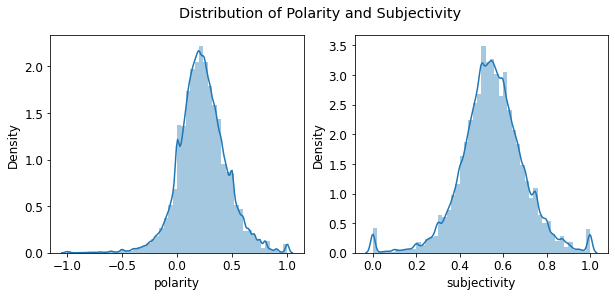

In [30]:
# plot the distribution of polarity and subjectivity to have a better visualization of the data
plt.rcParams["figure.figsize"] = (10, 4)
plt.subplot(1, 2, 1)
sns.distplot(df["polarity"])
plt.subplot(1, 2, 2)
sns.distplot(df["subjectivity"])
plt.suptitle("Distribution of Polarity and Subjectivity");

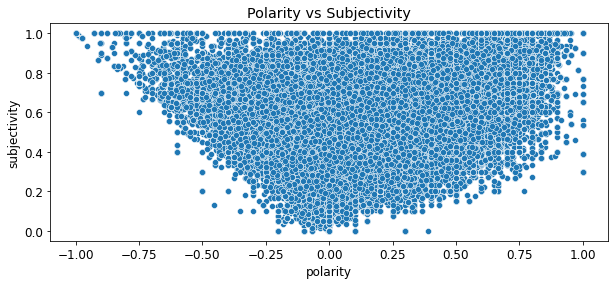

In [31]:
# plot the relation between polarity and subjectivity to have a better visualization of the data
sns.scatterplot(df["polarity"], df["subjectivity"])
plt.title("Polarity vs Subjectivity");

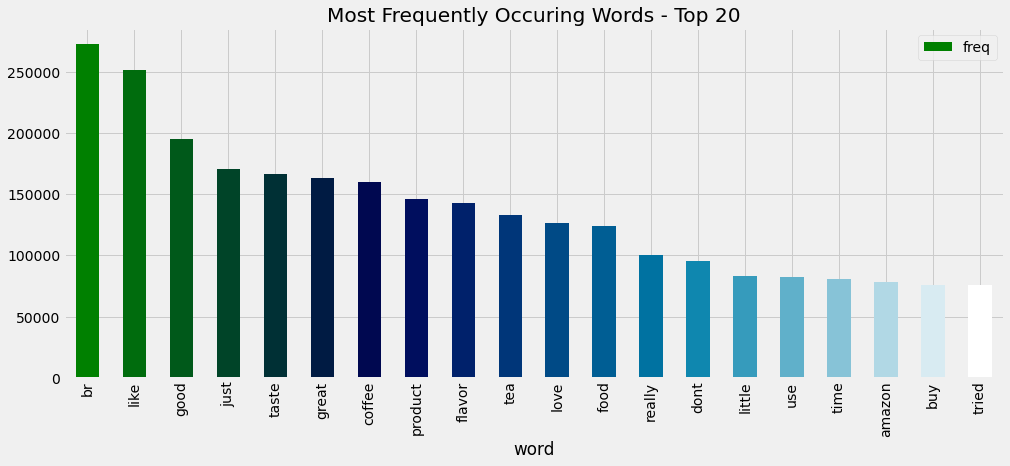

In [32]:
# visualize the most frequent words
cv = CountVectorizer(stop_words = "english")
words = cv.fit_transform(df.Text)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=["word", "freq"])

plt.style.use("fivethirtyeight")
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x="word", y="freq", kind="bar", figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20");

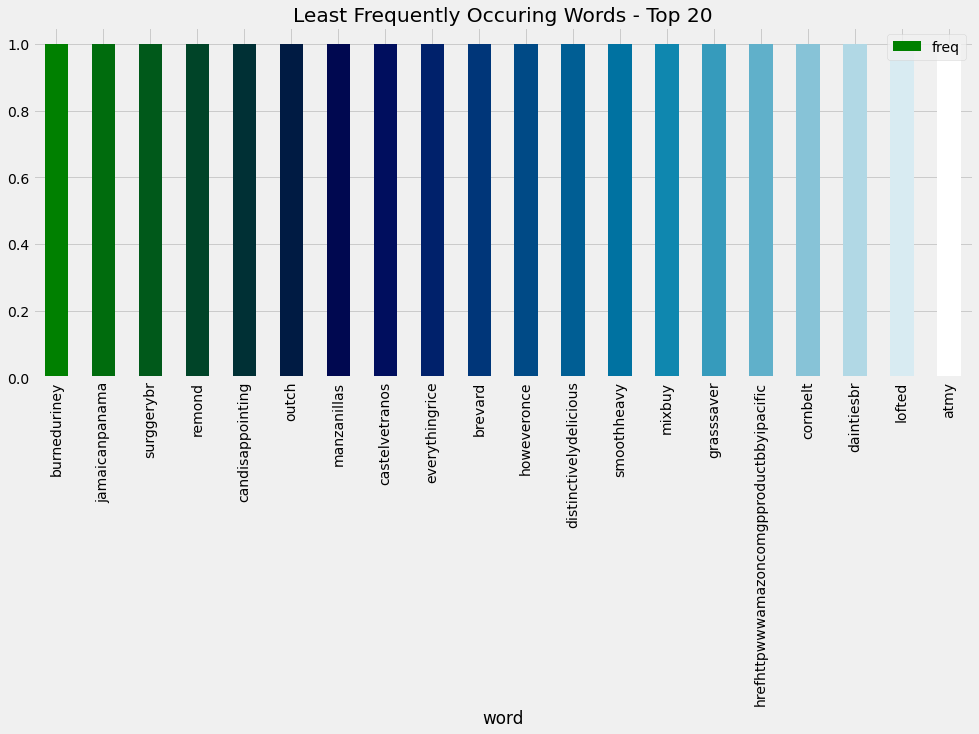

In [33]:
# visualize the least frequent words
cv = CountVectorizer(stop_words = "english")
words = cv.fit_transform(df.Text)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=["word", "freq"])

plt.style.use("fivethirtyeight")
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.tail(20).plot(x="word", y="freq", kind="bar", figsize=(15, 6), color = color)
plt.title("Least Frequently Occuring Words - Top 20");

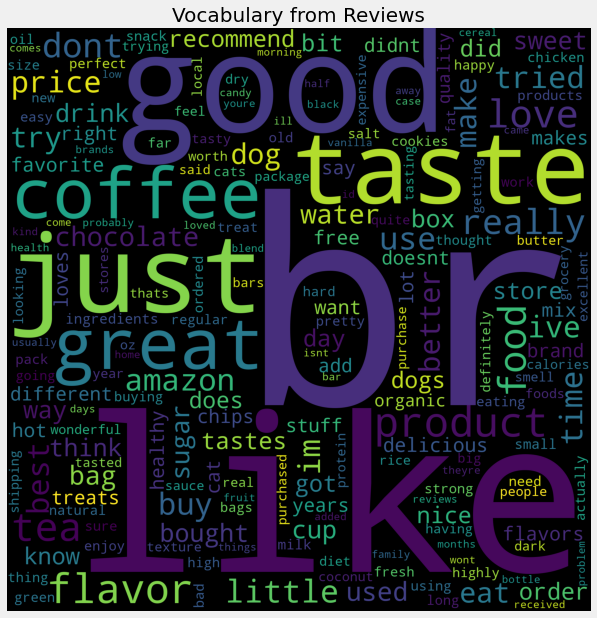

In [34]:
# visualize the Wordscloud where the bigger words are the most frequent
cv = CountVectorizer(stop_words = "english")
words = cv.fit_transform(df.Text)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
wordcloud = WordCloud(background_color = "black", width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use("fivethirtyeight")
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20);

In [35]:
# assign polarity values to a specific sentiment result
def polarity_sent(raw_txt):
    textblob = TextBlob(str(raw_txt))
    pol = textblob.sentiment.polarity
    if(pol==0):
        return "Neutral"
    elif(pol>0 and pol<=0.3):
        return "Weakly Positive"
    elif(pol>0.3 and pol<=0.6):
        return "Positive"
    elif(pol>0.6 and pol<=1):
        return "Strongly Positive"
    elif(pol>-0.3 and pol<=0):
        return "Weakly Negative"
    elif(pol>-0.6 and pol<=-0.3):
        return "Negative"
    elif(pol>=-1 and pol<=-0.6):
        return "Strongly Negative"
    
df['polarity'] = df['Text'].apply(polarity_sent)

In [36]:
df['polarity'].value_counts()

Weakly Positive      303827
Positive             170254
Weakly Negative       52593
Strongly Positive     26576
Neutral                8379
Negative               5389
Strongly Negative      1393
Name: polarity, dtype: int64

In [37]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length,char_count,word_count,word_density,punctuation_count,polarity,subjectivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,260,260,48,5.306122,0,Positive,0.433333
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,183,183,31,5.718750,0,Weakly Negative,0.762963
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,491,491,92,5.279570,0,Weakly Positive,0.448571
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,214,214,41,5.095238,0,Weakly Positive,0.533333
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price There was a wide...,135,135,27,4.821429,0,Positive,0.637500


## Trading signal

The trading signal I have designed for this type of alternative dataset is based on the sentiment analysis resulted from the polarity check of the text for the reviews. Here, we have many duplicates for each date and we will only consider the ones with the lowest subjectivity (in case of duplicated dates). One of the drawbacks is that there is not a daily frequency for reviews and this leads to lower positions on Amazon stock but also a mismatch that may affect our analysis. The webscraping should be constant to be up to date with the reviews submitted by customers and there is no need of big data since the text of the review has a lot of information we can extract and exploit to run a sentiment analysis and then a trading signal. Thus, the only technical requirements are: text of the review and constant data (preferred daily). The stock is bought when it has a sentiment higher than the neutral one (polarity = 0), it is sold whenever it is lower than the neutral, and it is held in case there is a neutral sentiment. This allows to dramatically increase our portfolio values.

In [38]:
# assign polarity values to a specific sentiment result
def polarity_sent(raw_txt):
    textblob = TextBlob(str(raw_txt))
    pol = textblob.sentiment.polarity
    if(pol==0):
        return "Neutral"
    elif(pol>0 and pol<=0.3):
        return "Weakly Positive"
    elif(pol>0.3 and pol<=0.6):
        return "Positive"
    elif(pol>0.6 and pol<=1):
        return "Strongly Positive"
    elif(pol>-0.3 and pol<=0):
        return "Weakly Negative"
    elif(pol>-0.6 and pol<=-0.3):
        return "Negative"
    elif(pol>=-1 and pol<=-0.6):
        return "Strongly Negative"
    
df['polarity'] = df['Text'].apply(polarity_sent)

In [39]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length,char_count,word_count,word_density,punctuation_count,polarity,subjectivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,260,260,48,5.306122,0,Positive,0.433333
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,183,183,31,5.718750,0,Weakly Negative,0.762963
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,491,491,92,5.279570,0,Weakly Positive,0.448571
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,214,214,41,5.095238,0,Weakly Positive,0.533333
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price There was a wide...,135,135,27,4.821429,0,Positive,0.637500


In [40]:
len(df)

568411

In [41]:
df = df.sort_values(["Time","subjectivity"])
df = df.set_index("Time")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,length,char_count,word_count,word_density,punctuation_count,polarity,subjectivity
Time,,,,,,,,,,,,,,,,
1999-10-08,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,EVERY book is educational,this witty little book makes my son laugh at l...,367,367,74,4.893333,0,Weakly Positive,0.555135
1999-10-25,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,388,388,76,5.038961,0,Weakly Positive,0.366667
1999-12-02,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,Entertainingl Funny!,Beetlejuice is a well written movie everythin...,159,159,28,5.482759,0,Positive,0.567857
1999-12-06,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,A modern day fairy tale,A twist of rumplestiskin captured on film star...,216,216,36,5.837838,0,Positive,0.750000
1999-12-06,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,A modern day fairy tale,A twist of rumplestiskin captured on film star...,216,216,36,5.837838,0,Positive,0.750000


In [42]:
# data cleaning to remove duplicated values for each single date, keeping its first value (lowest according to subjectivity)
index = df.index
is_duplicate = index.duplicated(keep="first")
not_duplicate = ~is_duplicate
no_duplicate_indeces = df[not_duplicate]
no_duplicate_indeces

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,length,char_count,word_count,word_density,punctuation_count,polarity,subjectivity
Time,,,,,,,,,,,,,,,,
1999-10-08,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,EVERY book is educational,this witty little book makes my son laugh at l...,367,367,74,4.893333,0,Weakly Positive,0.555135
1999-10-25,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,388,388,76,5.038961,0,Weakly Positive,0.366667
1999-12-02,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,Entertainingl Funny!,Beetlejuice is a well written movie everythin...,159,159,28,5.482759,0,Positive,0.567857
1999-12-06,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,A modern day fairy tale,A twist of rumplestiskin captured on film star...,216,216,36,5.837838,0,Positive,0.750000
2000-01-03,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,5,FANTASTIC!,Beetlejuice is an excellent and funny movie Ke...,236,236,43,5.363636,0,Strongly Positive,0.790035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-22,126331,B0000CES0O,ASOPXWAR6FU6N,Dana,0,0,5,cat grass,Been trying to find a grass that would grow an...,111,111,23,4.625000,0,Neutral,0.000000
2012-10-23,58995,B0020ZURDI,A35MNEH2EJV8H6,Miguel Espinoza,0,0,5,hasta ahora no tengo quejas,son muy buenos los colores hasta ahora estoy m...,124,124,21,5.636364,0,Neutral,0.000000
2012-10-24,16428,B007TJGZ54,A3V0B6OPOQZNDK,"Elisa Veneziano ""EV""",0,0,4,Morning coffee,I use this as my morning coffee wake up call ...,109,109,22,4.739130,0,Neutral,0.000000


In [43]:
# loading the Amazon prices csv file
amzn = pd.read_csv("AMZN.csv", usecols= ["Date","Adj Close"])
amzn = pd.DataFrame(amzn)
# data cleaning for the dates and index
amzn["Date"] = pd.to_datetime(amzn["Date"])
amzn = amzn.set_index("Date")
amzn.index.names = ['Time']

In [44]:
amzn.head()

,Adj Close
Time,
1998-05-22,7.166667
1998-05-26,6.822917
1998-05-27,7.218750
1998-05-28,7.161458
1998-05-29,7.343750


In [45]:
len(amzn)

3773

In [46]:
# compute Amazon returns
amzn = amzn.pct_change().dropna()
amzn["AMZN Rets"] = amzn["Adj Close"]
amzn = amzn.drop(["Adj Close"], axis=1)
amzn.head()

,AMZN Rets
Time,
1998-05-26,-0.047965
1998-05-27,0.058015
1998-05-28,-0.007937
1998-05-29,0.025455
1998-06-01,-0.028369


In [47]:
# merge the two DataFrames based on "Time"
trade_df = no_duplicate_indeces.merge(amzn, on="Time")
trade_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,length,char_count,word_count,word_density,punctuation_count,polarity,subjectivity,AMZN Rets
Time,,,,,,,,,,,,,,,,,
1999-10-08,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,EVERY book is educational,this witty little book makes my son laugh at l...,367,367,74,4.893333,0,Weakly Positive,0.555135,0.022190
1999-10-25,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,388,388,76,5.038961,0,Weakly Positive,0.366667,0.052464
1999-12-02,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,Entertainingl Funny!,Beetlejuice is a well written movie everythin...,159,159,28,5.482759,0,Positive,0.567857,0.047794
1999-12-06,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,A modern day fairy tale,A twist of rumplestiskin captured on film star...,216,216,36,5.837838,0,Positive,0.750000,0.013718
2000-01-03,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,5,FANTASTIC!,Beetlejuice is an excellent and funny movie Ke...,236,236,43,5.363636,0,Strongly Positive,0.790035,0.174056


In [48]:
# create a new DataFrame with only polarity and returns
trade_df = trade_df[["polarity","AMZN Rets"]]
trade_df

,polarity,AMZN Rets
Time,,
1999-10-08,Weakly Positive,0.022190
1999-10-25,Weakly Positive,0.052464
1999-12-02,Positive,0.047794
1999-12-06,Positive,0.013718
2000-01-03,Strongly Positive,0.174056
...,...,...
2012-10-22,Neutral,-0.025917
2012-10-23,Neutral,0.002267
2012-10-24,Neutral,-0.024839


In [49]:
len(trade_df)

2196

In [50]:
# create an empty column for the trade DataFrame
trade_df["signal"] = pd.NaT
trade_df.head()

,polarity,AMZN Rets,signal
Time,,,
1999-10-08,Weakly Positive,0.022190,NaT
1999-10-25,Weakly Positive,0.052464,NaT
1999-12-02,Positive,0.047794,NaT
1999-12-06,Positive,0.013718,NaT
2000-01-03,Strongly Positive,0.174056,NaT


In [51]:
# assign values to the polarity sentiment analysis outcomes
for step in range(len(trade_df.index)):
    if(trade_df["polarity"].iloc[step]=="Neutral"):
        trade_df["signal"].iloc[step] = +0.
    elif (trade_df["polarity"].iloc[step]=="Weakly Positive"):
        trade_df["signal"].iloc[step] = +0.3
    elif(trade_df["polarity"].iloc[step]=="Positive"):
        trade_df["signal"].iloc[step] = +0.6
    elif (trade_df["polarity"].iloc[step]=="Strongly Positive"):
        trade_df["signal"].iloc[step] = +1.
    elif (trade_df["polarity"].iloc[step]=="Weakly Negative"):
        trade_df["signal"].iloc[step] = -0.3
    elif(trade_df["polarity"].iloc[step]=="Negative"):
        trade_df["signal"].iloc[step] = -0.6
    elif (trade_df["polarity"].iloc[step]=="Strongly Negative"):
        trade_df["signal"].iloc[step] = -1.

In [52]:
trade_df.head()

,polarity,AMZN Rets,signal
Time,,,
1999-10-08,Weakly Positive,0.022190,0.3
1999-10-25,Weakly Positive,0.052464,0.3
1999-12-02,Positive,0.047794,0.6
1999-12-06,Positive,0.013718,0.6
2000-01-03,Strongly Positive,0.174056,1.0


In [53]:
# create a DataFrame considering only Amazon returns
trade_rets = pd.DataFrame(trade_df["AMZN Rets"])
trade_rets.head()

,AMZN Rets
Time,
1999-10-08,0.022190
1999-10-25,0.052464
1999-12-02,0.047794
1999-12-06,0.013718
2000-01-03,0.174056


In [54]:
def run_trade(trade_df, start=1):
    """
    Compute the Trading Strategy based on alternative dataset
    """
    # Set up the parameters
    dates = trade_df.index
    n_steps = len(dates)
    account_value = start
    if isinstance(trade_df, pd.Series): 
        trade_df = pd.DataFrame(trade_df, columns=["R"])
    
    # Creating DataFrames to store values
    account_history = pd.DataFrame().reindex_like(trade_rets)

    for step in range(n_steps):
        account_value += trade_df.iloc[step,2] * (1+trade_df.iloc[step,1])
        # Save the histories for analysis and plotting
        account_history.iloc[step] = account_value
    
    risky_wealth = start*(1+trade_rets).cumprod()
    backtest_result = {
        "alternative": account_history,
        "buy-and-hold": risky_wealth, 
    }
    return backtest_result

This trading strategy works with different weights assigned to the polarity metrics and the value of the portfolio evolves over time thanks to positive sentiment, whilst it decreases in case of negative sentiment. The data included in this analysis are backtested and compared to a simple buy-and-hold investment strategy

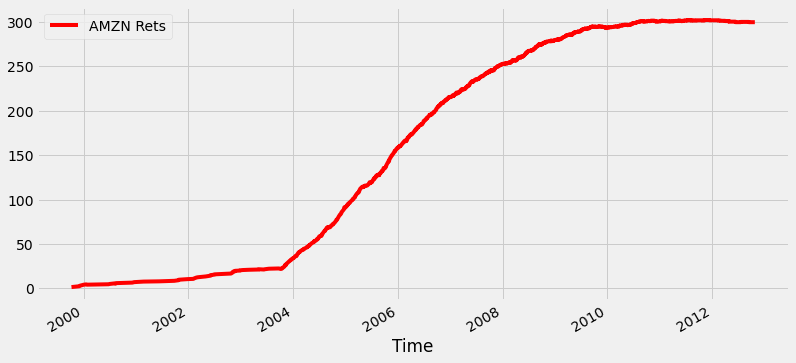

In [55]:
strat_df = run_trade(trade_df)
strat_df["alternative"].plot(figsize=(12,6), color = "r");

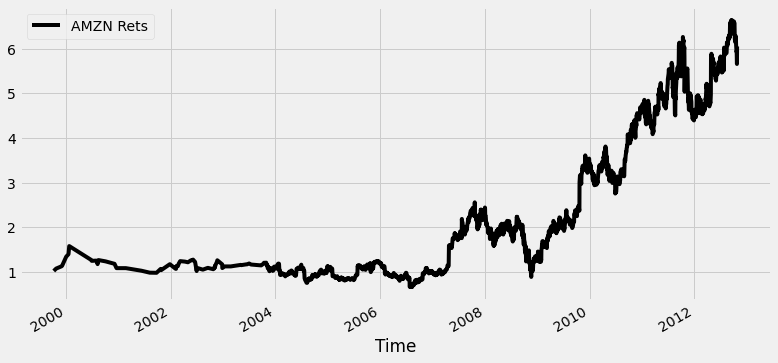

In [56]:
strat_df["buy-and-hold"].plot(figsize = (12,6), color = "k");

In [57]:
# calculate terminal wealth for an investment strategy based on Amazon reviews sentiment analysis
tw_strat = np.float64(strat_df["alternative"].iloc[-1])
round(tw_strat,2)

299.86

In [58]:
# calculate terminal wealth for a buy-and-hold investment strategy based on Amazon returns
tw_hold = np.float64(strat_df["buy-and-hold"].iloc[-1])
round(tw_hold,2)

6.05

In [59]:
# compute returns for the alternative investment strategy
alt_rets = strat_df["alternative"].pct_change().dropna()
alt_rets.columns = ["Alternative Data Returns"]
alt_rets.head()

,Alternative Data Returns
Time,
1999-10-25,0.241639
1999-12-02,0.387499
1999-12-06,0.270196
2000-01-03,0.410609
2000-01-19,0.077497


In [60]:
alt_rets.value_counts()

Alternative Data Returns
 0.000000                   1029
-0.077998                      1
 0.002589                      1
 0.002566                      1
 0.002565                      1
                            ... 
 0.001174                      1
 0.001174                      1
 0.001173                      1
 0.001170                      1
 0.410609                      1
Length: 1167, dtype: int64

In [61]:
# drop outliers represented by 0 values, since these are affected by the different dates
alt_rets = alt_rets[alt_rets != 0].dropna()
alt_rets.head()

,Alternative Data Returns
Time,
1999-10-25,0.241639
1999-12-02,0.387499
1999-12-06,0.270196
2000-01-03,0.410609
2000-01-19,0.077497


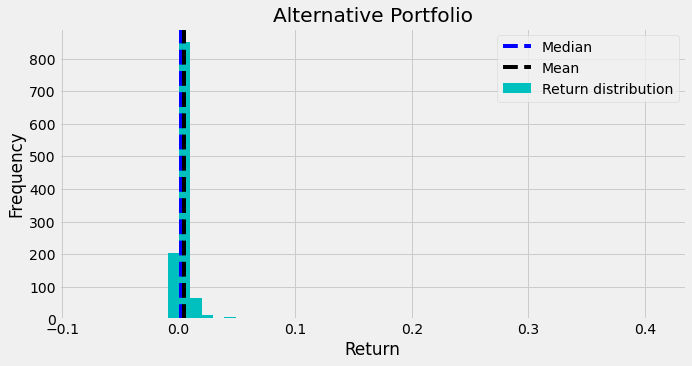

In [62]:
# Plot return distribution with median and mean for alternative portfolio
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
plt.axvline(np.float64(alt_rets.median()), color = "b", ls = "--")
plt.axvline(np.float64(alt_rets.mean()), color = "k", ls = "--")
alt_rets.hist(bins=50, ax=ax1, color = "c")
ax1.set_xlabel('Return')
ax1.set_ylabel('Frequency')
ax1.set_title('Alternative Portfolio')
plt.legend(["Median", "Mean", "Return distribution"]);

In [63]:
def annualize_rets(r, periods_per_year):
    """
    Annualize a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualize the volatility of a set of returns
    """
    return r.std()*(periods_per_year**0.5)


def drawdown (return_series: pd.Series):
    """
    Take a time series of asset returns and compute/return a DataFrame that contains:
    1. Wealth index
    2. Previous peaks
    3. Percent drawdowns
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks= wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": drawdown
    })


def skewness(r):
    """
    Compute the skewness of the supplied Series/DataFrame
    Alternative to scipy.stats.skew()
    Return a float/Series
    """
    demeaned_r = r - r.mean()
    # Use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Compute the kurtosis of the supplied Series/DataFrame
    Alternative to scipy.stats.kurtosis()
    Return a float/Series
    """
    demeaned_r = r - r.mean()
    # Use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def var_historic (r, level=5):
    """
    Compute Value-at-Risk Historic
    """
    if isinstance(r,pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance (r,pd.Series):
        return -np.percentile(r,level)
    else: 
        raise TypeError("Expected r to be Series or DataFrame")


def var_gaussian(r, level=5, modified=False):
    """
    Return the Parametric Gaussian Value-at-Risk of a Series/DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # Compute the Z-score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # Modify the Z-score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))


def cvar_historic(r, level=5):
    """
    Compute the Conditional Value-at-Risk of Series/DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")
        

def semideviation(r,periods_per_year=252):
    """
    Compute the Annualized Semi-Deviation
    """
    neg_rets = r[r<0]
    return annualize_vol(r = neg_rets, periods_per_year=periods_per_year)        
   

def rovar(r,periods_per_year,level=5):
    """
    Compute the Return on Value-at-Risk
    """
    return annualize_rets(r,periods_per_year=periods_per_year)/abs(var_historic(r,level=level))


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Compute the annualized Sharpe Ratio of a set of returns
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


def sortino_ratio(r, riskfree_rate, periods_per_year):
    """
    Compute the annualized Sortino Ratio of a set of returns
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    neg_rets = excess_ret[excess_ret<0]
    ann_vol = annualize_vol(neg_rets, periods_per_year)
    return ann_ex_ret/ann_vol


def calmar_ratio(r, riskfree_rate, periods_per_year):
    """
    Compute the annualized Calmar Ratio of a set of returns
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    max_dd = abs(drawdown(r).Drawdown.min())
    return ann_ex_ret/max_dd


def burke_ratio(r, riskfree_rate, periods_per_year, modified = False):
    """
    Compute the annualized Burke Ratio of a set of returns
    If "modified" is True, then the modified Burke Ratio is returned
    """
    # Convert the annual risk-free rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    sum_dwn = np.sqrt(np.sum((drawdown(r).Drawdown)**2))
    if modified == False:
        bk_ratio = ann_ex_ret/sum_dwn
    else:
        bk_ratio = ann_ex_ret/sum_dwn * np.sqrt(len(r))
    return bk_ratio


def summary_stats(r, riskfree_rate=0.03, periods_per_year=252):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=periods_per_year)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=periods_per_year)
    semidev = r.aggregate(semideviation, periods_per_year=periods_per_year)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    ann_cr = r.aggregate(calmar_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    ann_br = r.aggregate(burke_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year, modified = True)
    ann_sortr = r.aggregate(sortino_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    hist_var5 = r.aggregate(var_historic)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    rovar5 = r.aggregate(rovar, periods_per_year=periods_per_year)
    return pd.DataFrame({
        "Annualized Return": round(ann_r,4),
        "Annualized Volatility": round(ann_vol,4),
        "Semi-Deviation": round(semidev,4),
        "Skewness": round(skew,4),
        "Kurtosis": round(kurt,4),
        "Historic VaR (5%)": round(hist_var5,4),
        "Cornish-Fisher VaR (5%)": round(cf_var5,4),
        "Historic CVaR (5%)": round(hist_cvar5,4),
        "Return on VaR": round(rovar5,4),
        "Sharpe Ratio": round(ann_sr,4),
        "Sortino Ratio": round(ann_sortr,4),
        "Calmar Ratio": round(ann_cr,4),
        "Modified Burke Ratio": round(ann_br,4),
        "Max Drawdown": round(dd,4)
    })

In [64]:
# summary statistics for the alternative portfolio
summary_stats(alt_rets)

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
Alternative Data Returns,2.2375,0.3526,0.1073,12.7352,203.0179,0.0017,-0.206,0.006,1352.7918,6.0793,19.9842,27.4835,658.6908,-0.078


In [65]:
# summary statistics for the buy-and-hold portfolio
summary_stats(strat_df["buy-and-hold"].pct_change().dropna())

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown
AMZN Rets,0.2264,0.4755,0.3231,0.8452,16.5756,0.0383,0.0322,0.0634,5.9074,0.4009,0.591,0.2922,0.6749,-0.6525


The alternative portfolio gives favorable statistics but this could be improved by relying also on a risk-free asset. There could be a dynamic allocation based on this alternative dataset and a Portfolio Insurance strategy could be generated to protect the downside (limiting negative returns) during bearish markets, still guaranteeing performance in upmarkets (during bullish periods). The skewness is huge compared to the buy-and-hold and the kurtosis too. This gives a clue on the asymmetry and the extreme values it is subject to and we should be aware of.

## Additional analysis for specific words

In [66]:
neutral = 0
wpositive = 0
spositive = 0
positive = 0
negative = 0
wnegative = 0
snegative = 0
polarity = 0

for i in range(0,70):
    textblob = TextBlob(str(df["Text"][i]))
    polarity+= textblob.sentiment.polarity
    pol = textblob.sentiment.polarity
    if (pol == 0):  # adding reaction of how people are reacting to find average later
        neutral += 1
    elif (pol > 0 and pol <= 0.3):
        wpositive += 1
    elif (pol > 0.3 and pol <= 0.6):
        positive += 1
    elif (pol > 0.6 and pol <= 1):
        spositive += 1
    elif (pol > -0.3 and pol <= 0):
        wnegative += 1
    elif (pol > -0.6 and pol <= -0.3):
        negative += 1
    elif (pol > -1 and pol <= -0.6):
        snegative += 1

In [ ]:
# input for term to be searched and how many Review to search
searchTerm = input("Enter Keyword/Tag to search about: ")
NoOfTerms = int(input("Enter how many tweets to search: "))

In [ ]:
# finding average reaction
polarity = polarity / NoOfTerms
polarity

In [ ]:
# To calculate the Prsentage
def percentage(part, whole):
    temp = 100 * float(part) / float(whole)
    return format(temp, '.2f')

In [ ]:
 # finding average of how people are reacting
positive = percentage(positive, NoOfTerms)
wpositive = percentage(wpositive, NoOfTerms)
spositive = percentage(spositive, NoOfTerms)
negative = percentage(negative, NoOfTerms)
wnegative = percentage(wnegative, NoOfTerms)
snegative = percentage(snegative, NoOfTerms)
neutral = percentage(neutral, NoOfTerms)

In [ ]:
 # printing out data
print("How people are reacting on " + searchTerm + " by analyzing " + str(NoOfTerms) + " Review.")
print()
print("-----------------------------------------------------------------------------------------")
print()
print("General Report: ")

if (polarity == 0):
    print("Neutral")
elif (polarity > 0 and polarity <= 0.3):
    print("Weakly Positive")
elif (polarity > 0.3 and polarity <= 0.6):
    print("Positive")
elif (polarity > 0.6 and polarity <= 1):
    print("Strongly Positive")
elif (polarity > -0.3 and polarity <= 0):
    print("Weakly Negative")
elif (polarity > -0.6 and polarity <= -0.3):
    print("Negative")
elif (polarity >= -1 and polarity <= -0.6):
    print("Strongly Negative")

print()
print("------------------------------------------------------------------------------------------")
print()
print("Detailed Report: ")
print(str(positive) + "% people thought it was positive")
print(str(wpositive) + "% people thought it was weakly positive")
print(str(spositive) + "% people thought it was strongly positive")
print(str(negative) + "% people thought it was negative")
print(str(wnegative) + "% people thought it was weakly negative")
print(str(snegative) + "% people thought it was strongly negative")
print(str(neutral) + "% people thought it was neutral")

In [ ]:
# Define the sentance to Plot the Pieplot 
sizes = [positive, wpositive, spositive, neutral, negative, wnegative, snegative]
colors = ['yellowgreen','lightgreen','darkgreen', 'gold', 'red','lightsalmon','darkred']
labels = ['Positive [' + str(positive) + '%]', 'Weakly Positive [' + str(wpositive) + '%]',
          'Strongly Positive [' + str(spositive) + '%]', 'Neutral [' + str(neutral) + '%]',
          'Negative [' + str(negative) + '%]', 'Weakly Negative [' + str(wnegative) + '%]', 
          'Strongly Negative [' + str(snegative) + '%]']

In [ ]:
plt.pie(sizes, labels = labels, colors = colors)
plt.legend(labels, loc="best")
plt.title('How people are reacting on ' + searchTerm + ' by analyzing ' + str(NoOfTerms) + ' Tweets.')
plt.axis('equal')
plt.tight_layout();